## QDenseBatchnorm Test Notebook
***
QDenseBatchnorm should fold quantized Dense parameters into the the Batchnorm layer to reduce the LUT (look up table) utilization at HLS and Vivado FPGA Implementation time

In [8]:
import common as com
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation
from tensorflow.keras.regularizers import l1
from qkeras.qlayers import QDense, QActivation
from qkeras import QDenseBatchnorm
from qkeras.quantizers import quantized_bits, quantized_relu
import os
import hls4ml
from plot_roc import plot_roc
import subprocess
%matplotlib inline
os.environ['PATH'] = '/opt/local/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']
os.environ['PATH'] = '/tools/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']

In [9]:
def reference_model(bits=12, int_bits=0, relu_bits = 6):
    '''
    define the reference quantized model for the autoencoder, with fewer layers
    '''
    inputLayer = Input(shape=(128))
    kwargs = {
        'kernel_quantizer': quantized_bits(bits, int_bits, alpha=1),
        'bias_quantizer': quantized_bits(bits, int_bits, alpha=1),
        'kernel_initializer': 'lecun_uniform',
        'kernel_regularizer': l1(0) 
    }
    
    #declare encoder
    h = QDense(64, **kwargs)(inputLayer)
    h = BatchNormalization()(h)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    h = QDense(64, **kwargs)(h)
    h = BatchNormalization()(h)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)

    # h = QDense(64, **kwargs)(h)
    # h = BatchNormalization()(h)
    # h = QActivation(activation=quantized_relu(relu_bits,0))(h)

    # h = QDense(64, **kwargs)(h)
    # h = BatchNormalization()(h)
    # h = QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    #declare latent layer
    h = h = QDense(8, **kwargs)(h)
    h = BatchNormalization()(h)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    #declare decoder
    h = QDense(64, **kwargs)(h)
    h = BatchNormalization()(h)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    h = h = QDense(64, **kwargs)(h)
    h = BatchNormalization()(h)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)

    # h = QDense(64, **kwargs)(inputLayer)
    # h = BatchNormalization()(h)
    # h = QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    # h = QDense(64, **kwargs)(h)
    # h = BatchNormalization()(h)
    # QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    #output layer
    h = QDense(128, **kwargs)(h)
    
    return Model(inputs=inputLayer, outputs=h)

    
def qdense_batchnorm_model(bits=12, int_bits=0, relu_bits = 6):
    '''
    define the densebatchnorm quantized model for the autoencoder, with fewer layers
    '''
    inputLayer = Input(shape=(128))
    kwargs = {
        'kernel_quantizer': quantized_bits(bits, int_bits, alpha=1),
        'bias_quantizer': quantized_bits(bits, int_bits, alpha=1),
        'kernel_initializer': 'lecun_uniform',
        'kernel_regularizer': l1(0) 
    }
    
    #declare encoder
    h = QDenseBatchnorm(64, **kwargs)(inputLayer)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    h = QDenseBatchnorm(64, **kwargs)(h)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)

    # h = QDenseBatchnorm(64, **kwargs)(h)
    # h = QActivation(activation=quantized_relu(relu_bits,0))(h)

    # h = QDenseBatchnorm(64, **kwargs)(h)
    # h = QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    #declare latent layer
    h = QDenseBatchnorm(8, **kwargs)(h)
    h = QActivation(activation=quantized_relu(relu_bits))(h)
    
    #declare decoder
    h = QDenseBatchnorm(64, **kwargs)(h)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)

    h = QDenseBatchnorm(64, **kwargs)(h)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)

    # h = QDenseBatchnorm(64, **kwargs)(inputLayer)
    # h = QActivation(activation=quantized_relu(relu_bits,0))(h)

    # h = QDenseBatchnorm(64, **kwargs)(inputLayer)
    # h = QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    #output layer
    h = QDense(128, **kwargs)(h)
    
    return Model(inputs=inputLayer, outputs=h)


### Create Train Data using ToyADMOS toy car dataset

In [10]:
if not os.path.exists('./dev_data'):
    rc = subprocess.call("./get_dataset.sh")
param = com.yaml_load('data_gen_config.yml')
param = param["train"]
train_data_save_load_directory = "./train_time_data/train_data_inputs_{}_frames_{}_hops_{}_fft_{}_mels_{}_power_{}_downsample_{}.npy".format(
        param["model"]["input_dim"],param["feature"]["frames"], param["feature"]["hop_length"], 
            param["feature"]["n_fft"], param["feature"]["n_mels"], param["feature"]["power"],param["feature"]["downsample"],)
        
# if train_data available, load processed data in local directory without reprocessing wav files --saves time--
if os.path.exists(train_data_save_load_directory):
    print("Loading train_data from {}".format(train_data_save_load_directory))
    train_data = np.load(train_data_save_load_directory)
else:
    !python generate_train_data.py -c data_gen_config.yml
    train_data = np.load(train_data_save_load_directory)

Loading train_data from ./train_time_data/train_data_inputs_128_frames_5_hops_512_fft_1024_mels_128_power_2.0_downsample_True.npy


### train and test reference and qdense_batchnorm model

In [11]:
if not os.path.exists('./model/ref/reference_model.h5'):
    ref_model = reference_model()
    ref_model.compile(loss='mean_squared_error', optimizer='adam')
    ref_model.fit(train_data, train_data, batch_size=512, epochs=20, shuffle=1,validation_split=0.1, verbose=1)
    ref_model.save('./model/qdbn/reference_model.h5')
else:
    ref_model = com.load_model('./model/ref/reference_model.h5')
ref_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 q_dense (QDense)            (None, 64)                8256      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 q_activation (QActivation)  (None, 64)                0         
                                                                 
 q_dense_1 (QDense)          (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                             

In [12]:
if not os.path.exists('./model/qdbn/qdbn_model.h5'):
    qdbn_model = qdense_batchnorm_model()
    qdbn_model.compile(loss='mean_squared_error', optimizer='adam')
    qdbn_model.fit(train_data, train_data, batch_size=512, epochs=20, shuffle=1,validation_split=0.1, verbose=1)
    qdbn_model.save('./model/qdbn/qdbn_model.h5')
else:
    qdbn_model = com.load_model('./model/qdbn/qdbn_model.h5')
qdbn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 q_dense_batchnorm (QDenseBa  (None, 64)               8513      
 tchnorm)                                                        
                                                                 
 q_activation_5 (QActivation  (None, 64)               0         
 )                                                               
                                                                 
 q_dense_batchnorm_1 (QDense  (None, 64)               4417      
 Batchnorm)                                                      
                                                                 
 q_activation_6 (QActivation  (None, 64)               0         
 )                                                         

### Compare QDenseBN (qdbn_model) and QDense->BN (ref_model) peformance

In [13]:
# if train_data available, load processed data in local directory without reprocessing wav files --saves time--
X_npy_dir =  './test_data/anomaly_detection/128input_test_data.npy'
y_npy_dir = './test_data/anomaly_detection/128input_test_data_ground_truths.npy'
X = np.load('./test_data/anomaly_detection/128input_test_data.npy', allow_pickle=True)

using one quarter of provided dataset for roc plot


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

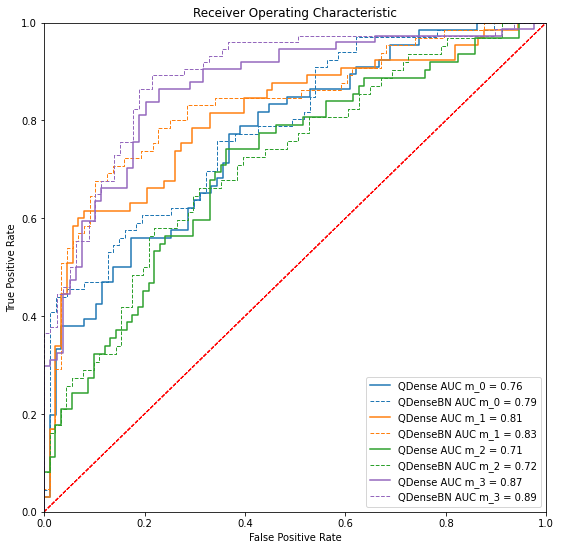

In [14]:
plot_roc(ref_model, qdbn_model, X_npy_dir, y_npy_dir, data_split_factor=4)

### HLS4ML Translation of QDenseBN and QDense->BN models

#### QDenseBN Model first

In [24]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'
hls_config = com.yaml_load('model/qdbn/hls4ml_config.yml')
hls_config = hls_config['HLSConfig']
hls_config['Model']['ReuseFactor'] = 16384
hls_config['Model']['Strategy'] = 'Resource'
hls_config['Model']['Precision'] = 'ap_fixed<32,16>'
hls_config['LayerName']['input_1']['Precision'] = 'ap_fixed<8,8>'
for layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][layer]['Trace'] = True
    hls_config['LayerName'][layer]['accum_t'] = 'ap_fixed<32,16>'
    hls_config['LayerName'][layer]['ReuseFactor'] = 16384

backend='VivadoAccelerator'
clock_period=10
io_type='io_stream' 
interface='axi-stream'
cfg = hls4ml.converters.create_config(
            backend='VivadoAccelerator',
            part='xc7z020clg400-1',
            clock_period=10,
            io_type='io_stream')

cfg['HLSConfig'] = hls_config
cfg['InputData'] = 'test_data/anomaly_detection/test_bench/128input_test_data.npy'
cfg['OutputPredictions'] = 'test_data/anomaly_detection/test_bench/128input_test_data.npy'
cfg['KerasModel'] = qdbn_model
cfg['OutputDir'] = 'hls/qdbn_prj'

print("-----------------------------------")
com.print_dict(cfg)
print("-----------------------------------")

qdbn_hls_model = hls4ml.converters.keras_to_hls(cfg)

qdbn_hls_model.compile()

-----------------------------------
OutputDir:           hls/qdbn_prj
ProjectName:         myproject
Backend:             VivadoAccelerator
XilinxPart:          xc7z020clg400-1
Board:               pynq-z2
ClockPeriod:         10
IOType:              io_stream
HLSConfig
  LayerName
    input_1
      Precision:     ap_fixed<8,8>
      ReuseFactor:   16384
      Trace:         True
      accum_t:       ap_fixed<32,16>
    q_activation
      Precision
        result:      ap_ufixed<7,1>
      ReuseFactor:   16384
      Trace:         True
      accum_t:       ap_fixed<32,16>
    q_activation_1
      Precision
        result:      ap_ufixed<7,1>
      ReuseFactor:   16384
      Trace:         True
      accum_t:       ap_fixed<32,16>
    q_activation_2
      Precision
        result:      ap_ufixed<7,1>
      ReuseFactor:   16384
      Trace:         True
      accum_t:       ap_fixed<32,16>
    q_activation_3
      Precision
        result:      ap_ufixed<7,1>
      ReuseFactor:   16384
 

#### Reference QKeras Model

In [15]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'
hls_config = com.yaml_load('model/ref/hls4ml_config.yml')
hls_config = hls_config['HLSConfig']
hls_config['Model']['ReuseFactor'] = 16384
hls_config['Model']['Strategy'] = 'Resource'
hls_config['Model']['Precision'] = 'ap_fixed<32,16>'
hls_config['LayerName']['input_1']['Precision'] = 'ap_fixed<8,8>'
for layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][layer]['Trace'] = True
    hls_config['LayerName'][layer]['accum_t'] = 'ap_fixed<32,16>'
    hls_config['LayerName'][layer]['ReuseFactor'] = 16384

backend='VivadoAccelerator'
clock_period=10
io_type='io_stream' 
interface='axi-stream'
cfg = hls4ml.converters.create_config(
            backend='VivadoAccelerator',
            part='xc7z020clg400-1',
            clock_period=10,
            io_type='io_stream')

cfg['HLSConfig'] = hls_config
cfg['InputData'] = 'test_data/anomaly_detection/test_bench/128input_test_data.npy'
cfg['OutputPredictions'] = 'test_data/anomaly_detection/test_bench/128input_test_data.npy'
cfg['KerasModel'] = ref_model
cfg['OutputDir'] = 'hls/ref_prj'

print("-----------------------------------")
com.print_dict(cfg)
print("-----------------------------------")

ref_hls_model = hls4ml.converters.keras_to_hls(cfg)

ref_hls_model.compile()

-----------------------------------
OutputDir:           hls/ref_prj
ProjectName:         myproject
Backend:             VivadoAccelerator
XilinxPart:          xc7z020clg400-1
Board:               pynq-z2
ClockPeriod:         10
IOType:              io_stream
HLSConfig
  LayerName
    batch_normalization
      Precision
        bias:        ap_fixed<16,6>
        scale:       ap_fixed<16,6>
      ReuseFactor:   16384
      Trace:         True
      accum_t:       ap_fixed<32,16>
    batch_normalization_1
      Precision
        bias:        ap_fixed<16,6>
        scale:       ap_fixed<16,6>
      ReuseFactor:   16384
      Trace:         True
      accum_t:       ap_fixed<32,16>
    batch_normalization_2
      Precision
        bias:        ap_fixed<16,6>
        scale:       ap_fixed<16,6>
      ReuseFactor:   16384
      Trace:         True
      accum_t:       ap_fixed<32,16>
    batch_normalization_3
      Precision
        bias:        ap_fixed<16,6>
        scale:       ap_fixed<

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128]], output shape: [None, 128]
Layer name: q_dense, layer type: QDense, input shapes: [[None, 128]], output shape: [None, 64]
BatchNormalization
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_dense_1, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 64]
BatchNormalization
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_dense_2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 8]
BatchNormalization
Layer name: batch_normalization_2, layer type: BatchNormalization, input shapes: [

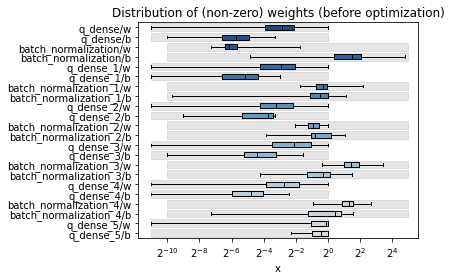

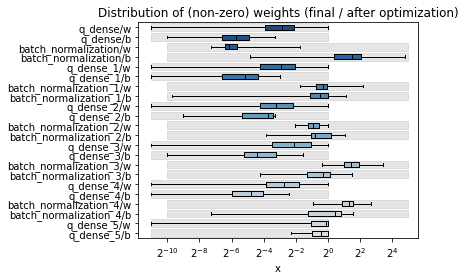

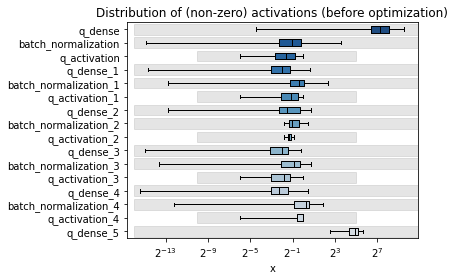

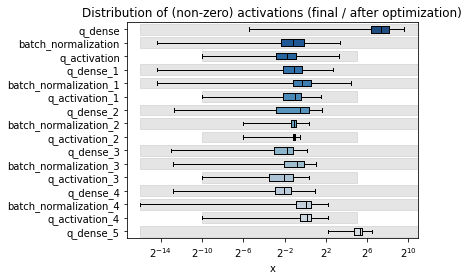

In [16]:
_= hls4ml.model.profiling.numerical(model=ref_model, hls_model=ref_hls_model, X=X[0][0])

using one quarter of provided dataset for roc plot


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

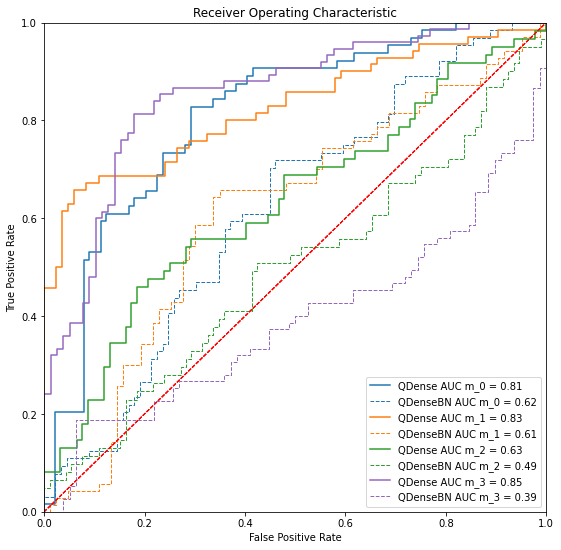

In [17]:
plot_roc(ref_model, ref_hls_model, X_npy_dir, y_npy_dir,data_split_factor=4)

### Compare performance of HLS (C++) QDenseBN vs QDense->BN

In [ ]:
plot_roc(ref_hls_model, qdbn_hls_model, X_npy_dir, y_npy_dir,data_split_factor=4)

In [ ]:
ref_hls_model.build(reset=False, csim=True, cosim=True, validation=True, synth=True, vsynth=True, export=True)
hls4ml.report.read_vivado_report('hls/ref_prj')

In [ ]:
qdbn_hls_model.build(reset=False, csim=True, cosim=True, validation=True, synth=True, vsynth=True, export=True)
hls4ml.report.read_vivado_report('hls/qdbn_prj')